In [97]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from argparse import ArgumentParser
import yaml
import sys
import json
from shutil import copyfile
import logging
import torch
import torch.nn as nn
import pickle
import numpy as np
import pdb
from monai.data import DataLoader, DistributedSampler
from dataset_scene_2d import build_scene_graph_data
from utils import image_graph_collate_scene_graph
from trainer import build_trainer
from models import build_model
from models.matcher_scene import build_matcher
from losses import SetCriterion
from datasets.sparse_targets import FrequencyBias
from inference import graph_infer
# %matplotlib widget
sys.path.append("..")
from torch.utils.tensorboard import SummaryWriter
from scipy import ndimage
from scipy.sparse import csr_matrix
import box_ops_2D as box_ops
import matplotlib.pyplot as plt
from matplotlib import text, patheffects
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import networkx as nx
from util.sg_recall import BasicSceneGraphEvaluator
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = "/mnt/nfsd3/data/obj_count.pkl"

In [3]:
with open(path, 'rb') as f:
    weight = np.array(pickle.load(f)).T
sorted_weight = weight[np.argsort(np.int16(weight[:, 1]))]
cls_weight = np.float32(sorted_weight[:,2])/62723.0
eps = np.expand_dims(np.array(300-np.sum(cls_weight)), 0)
cls_weight = np.concatenate([eps, cls_weight], 0)
cls_weight = 1.0/cls_weight
cls_weight = 300.0*cls_weight/cls_weight.sum()

In [4]:
class_dict = sorted_weight[:,:2][:,[1,0]]

In [5]:
class_dict = {np.int(e[0]):e[1] for e in class_dict}

In [101]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def plot_coco_sample(image, bboxes, labels, rel, relative_coords=True):
    image = np.clip(image*std+mean, 0, 1)
    H, W = image.shape[0], image.shape[1]
    fig, ax = plt.subplots(figsize=(12,5), dpi=150)
    gridspec.GridSpec(1,5)
    ax = plt.subplot2grid((1,5), (0,0), colspan=2, rowspan=1)

    # Displaying the image
    ax.imshow(image)
    ax.axis('off')

    # Bounding boxes
    for idx, (bbox, label) in enumerate(zip(bboxes, labels)):
        l, t, r, b = bbox * [W, H, W, H] if relative_coords else bbox
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t),
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax.add_patch(rect)
        ax.text(l,(t-H*0.05), class_dict[label], verticalalignment='top', color='white',fontsize=10,weight='bold').set_path_effects([patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])
    
    ax = plt.subplot2grid((1,5), (0,2), colspan=3, rowspan=1)
    G = nx.DiGraph()
    edges = [tuple(rel[:2]) for rel in rel]
    nodes = list(np.unique(np.array(edges)))
    labeldict = {}
    tmp = [labeldict.update({i: class_dict[l]}) for i, l in zip(nodes, labels[nodes])]
    coord_dict = {}
    tmp = [coord_dict.update({i:(H*(box[0]+box[2])/2.0, W-W*(box[1]+box[3])/2.0)}) for i,box in enumerate(bboxes)]
    edge_labeldict = {}
    tmp = [edge_labeldict.update({edges[i]: ind_2_pred[str(l[2])]}) for i,l in enumerate(rel)]

    G.add_nodes_from(nodes)
    #for n, p in coord_dict.items():
    #    G.nodes[n]['pos'] = p
    G.add_edges_from(edges)
    #pos = nx.get_node_attributes(G,'pos')
    #pos = nx.rescale_layout_dict(pos)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax, labels=labeldict, node_size=[len(i[1])**2 * 60 for i in labeldict.items()], node_color='lightcoral', edge_color='mediumorchid', width=1.5, font_size=12, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labeldict, font_size=12, label_pos=0.5, rotate=False)
    
    plt.show()
    
def plot_val_sample(image, bboxes1, bboxes2, labels1, labels2, relative_coords=True):
    image = np.clip(image*std+mean, 0, 1)
    H, W = image.shape[0], image.shape[1]
    fig, ax = plt.subplots(1,2,dpi=150)

    # Displaying the image
    ax[0].imshow(image)
    ax[1].imshow(image)

    # Bounding boxes
    for idx, (bbox, label1) in enumerate(zip(bboxes1, labels1)):
        l, t, r, b = bbox * [W, H, W, H] if relative_coords else bbox
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t),
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(l,(t-H*0.05), class_dict[label1], verticalalignment='top', color='white',fontsize=10,weight='bold').set_path_effects([patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])
    
    for idx, (bbox, label2) in enumerate(zip(bboxes2, labels2)):
        l, t, r, b = bbox * [W, H, W, H] if relative_coords else bbox
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t),
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(l,(t-H*0.05), class_dict[label2], verticalalignment='top', color='white',fontsize=10,weight='bold').set_path_effects([patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])
        
    plt.show()

def plot_val_rel_sample(image, bboxes1, bboxes2, labels1, labels2, rel1, rel2, attn_map=None, relative_coords=True):
    image = np.clip(image*std+mean, 0, 1)
    H, W = image.shape[0], image.shape[1]
    fig, ax = plt.subplots(1,5, figsize=(25,5), dpi=150)

    # Displaying the image
    ax[0].imshow(image)
    ax[1].imshow(image)
    ax[0].axis('off')
    ax[1].axis('off')

    # Bounding boxes
    for idx, (bbox, label1) in enumerate(zip(bboxes1, labels1)):
        l, t, r, b = bbox * [W, H, W, H] if relative_coords else bbox
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t),
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(l,(t-H*0.05), class_dict[label1], verticalalignment='top', color='white',fontsize=10,weight='bold').set_path_effects([patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])
    
    for idx, (bbox, label2) in enumerate(zip(bboxes2, labels2)):
        l, t, r, b = bbox * [W, H, W, H] if relative_coords else bbox
        rect = patches.Rectangle((l, t), width=(r - l), height=(b - t),
                                 linewidth=1, edgecolor='#76b900', facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(l,(t-H*0.05), class_dict[label2], verticalalignment='top', color='white',fontsize=10,weight='bold').set_path_effects([patheffects.Stroke(linewidth=4, foreground='black'), patheffects.Normal()])
   
    G = nx.DiGraph()
    edges = [tuple(rel[:2]) for rel in rel1]
    nodes = list(np.unique(np.array(edges)))
    labeldict = {}
    tmp = [labeldict.update({i: class_dict[l]}) for i, l in zip(nodes, labels1[nodes])]
    coord_dict = {}
    tmp = [coord_dict.update({i:(H*(box[0]+box[2])/2.0, W-W*(box[1]+box[3])/2.0)}) for i,box in enumerate(bboxes1)]
    edge_labeldict = {}
    tmp = [edge_labeldict.update({edges[i]: ind_2_pred[str(l[2])]}) for i,l in enumerate(rel1)]
    G.add_nodes_from(nodes)
    #for n, p in coord_dict.items():
    #    G.nodes[n]['pos'] = p
    G.add_edges_from(edges)
    #pos = nx.get_node_attributes(G,'pos')
    #pos = nx.rescale_layout_dict(pos)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax[2], labels=labeldict, node_size=[len(i[1])**2 * 20 for i in labeldict.items()], node_color='lightcoral', edge_color='mediumorchid', width=1, font_size=8, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, ax=ax[2], edge_labels=edge_labeldict, font_size=8, label_pos=0.5, rotate=False)
    
    G = nx.DiGraph()
    edges = [tuple(rel[:2]) for rel in rel2]
    nodes = list(np.unique(np.array(edges).flatten()))
    labeldict = {}
    tmp = [labeldict.update({i: class_dict[l]}) for i, l in zip(nodes, labels2[nodes])]
    coord_dict = {}
    tmp = [coord_dict.update({i:(H*(box[0]+box[2])/2.0, W-W*(box[1]+box[3])/2.0)}) for i,box in enumerate(bboxes2)]
    edge_labeldict = {}
    tmp = [edge_labeldict.update({edges[i]: ind_2_pred[str(l[2])]}) for i,l in enumerate(rel2)]
    G.add_nodes_from(nodes)
    #for n, p in coord_dict.items():
    #    G.nodes[n]['pos'] = p
    G.add_edges_from(edges)
    #pos = nx.get_node_attributes(G,'pos')
    #pos = nx.rescale_layout_dict(pos)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax[3], labels=labeldict, node_size=[len(i[1])**2 * 20 for i in labeldict.items()], node_color='lightcoral', edge_color='mediumorchid', width=1, font_size=8,with_labels=True)
    nx.draw_networkx_edge_labels(G, pos, ax=ax[3], edge_labels=edge_labeldict, font_size=8, label_pos=0.5, rotate=False)
    tokens = [class_dict[l] for l in labels2[nodes]]
    nodes.append(attn_map.shape[0]-1)
    im = ax[4].imshow(attn_map[:,nodes][nodes,:], origin='lower')
    tokens.append('[rln]-token')
    # Show all ticks and label them with the respective list entries
    ax[4].set_xticks(np.arange(len(tokens)))
    ax[4].set_yticks(np.arange(len(tokens)))
    ax[4].set_xticklabels(tokens)
    ax[4].set_yticklabels(tokens)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax[4].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    plt.show()

In [7]:
class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
        
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

In [98]:
config_file = "/media/Drives/Data/transformer_graph_gen/output1/Data/transformer_graph_gen/test.yaml"
#config_file = "/media/Drives/Data/transformer_graph_gen/configs/scene_2D_seresnet_64_detr.yaml"
with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config = dict2obj(config)

## Debug Dataloader

In [9]:
device = "cuda"

In [10]:
train_ds, val_ds = build_scene_graph_data(config, mode='split', debug=False)

# mn_dataset_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple([y_.to(device) for y_ in x_] for x_ in image_graph_collate(x)))

train_loader = DataLoader(train_ds,
                            batch_size=config.DATA.BATCH_SIZE,
                            num_workers=config.DATA.NUM_WORKERS,
                            collate_fn=image_graph_collate_scene_graph,
                            pin_memory=True,
                            sampler= None,)
val_loader = DataLoader(val_ds,
                            batch_size=config.DATA.BATCH_SIZE,
                            num_workers=config.DATA.NUM_WORKERS,
                            collate_fn=image_graph_collate_scene_graph,
                            pin_memory=True,
                            sampler= None,)

In [99]:
sg_evaluator = BasicSceneGraphEvaluator.all_modes(multiple_preds=False,config=config)#todo replace wd param

In [18]:
iteration = 0
for images, gt_datas in train_loader:
#     print(targets[0]["orig_size"])
    
    boxes = [data['boxes'].to(device, non_blocking=False) for data in gt_datas]
    labels = gt_datas[0]['labels'].data.cpu().numpy()
    boxes_class = [data['labels'].cpu().numpy()-1.0 for data in gt_datas]
    boxes_score = [np.ones(data['labels'].shape[0]) for data in gt_datas]
    edges = [data['edges'].cpu().numpy() for data in gt_datas]
    bbox = box_ops.box_cxcywh_to_xyxy(boxes[0]).data.cpu().numpy()
    iteration = iteration+1
    
    print('Iteration:',iteration)
    plot_coco_sample(images[0].permute(1,2,0), bbox, labels, edges[0])

ERROR! Session/line number was not unique in database. History logging moved to new session 6086


NameError: name 'train_loader' is not defined

## Debug Model

In [12]:
model = build_model(config)
model = model.to(device)
if config.MODEL.DECODER.FREQ_BIAS: # use freq bias
    freq_baseline = FrequencyBias(config.DATA.FREQ_BIAS, train_ds)
net_wo_dist = model
relation_embed = model.relation_embed
freq_baseline = freq_baseline.to(device) if config.MODEL.DECODER.FREQ_BIAS else None

## Debug Trained Model

In [27]:
ckpt_path = '/media/Drives/Data/transformer_graph_gen/output1/Data/transformer_graph_gen/runs/visulagenome_200_edgeloss_6_fulltrain_final_scales_b16_10/models/checkpoint_epoch=27 (copy).pt'
checkpoint = torch.load(ckpt_path, map_location='cpu')
missing_keys, unexpected_keys = model.load_state_dict(checkpoint['net'], strict=False)
unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
if len(missing_keys) > 0:
    print('Missing Keys: {}'.format(missing_keys))
if len(unexpected_keys) > 0:
    print('Unexpected Keys: {}'.format(unexpected_keys))

In [28]:
ind_2_pred = json.load(open(config.DATA.LABEL_DATA_DIR))['idx_to_predicate']

In [1]:
model.eval()
iteration = 0
for images, gt_datas in val_loader:
    print(images[0].shape)
    images = [image.to(device,  non_blocking=False) for image in images]
    boxes = [data['boxes'].to(device, non_blocking=False) for data in gt_datas]
    labels1 = gt_datas[0]['labels'].data.cpu().numpy()
    boxes_class = [data['labels'].cpu().numpy()-1.0 for data in gt_datas]
    boxes_score = [np.ones(data['labels'].shape[0]) for data in gt_datas]
    edges1 = [data['edges'].cpu().numpy() for data in gt_datas]
    bbox1 = box_ops.box_cxcywh_to_xyxy(boxes[0]).data.cpu().numpy()

    model.eval()
    h, out1 = model(images)  # todo output logit and edge are same value
    relation_embed = model.relation_embed
    out = graph_infer(h, out1, relation_embed, rln_token=config.MODEL.DECODER.RLN_TOKEN,
                          apply_nms=False, freq=freq_baseline, emb=config.MODEL.DECODER.ADD_EMB_REL)
    
    pred_edges = [{'node_pair': pred_rels, 'edge_score': edge_score} for pred_rels, edge_score in zip(out['all_node_pairs'], out['all_relation'])]
    pred_classes = [{'labels': pred_class+1, 'scores': pred_score, 'boxes': torch.tensor(pred_box)} for pred_class, pred_score, pred_box in zip(out['pred_boxes_class'], out['pred_boxes_score'], out['pred_boxes'])]

    for i, (gt_data, pred_class, pred_edge) in enumerate(zip(gt_datas, pred_classes, pred_edges)):
        # prepare scene graph evaluation
        res = sg_evaluator['sgdet'].evaluate_scene_graph_entry(gt_data,[pred_class, pred_edge])
        break
    
    bbox2 = box_ops.box_cxcywh_to_xyxy(torch.tensor(out['pred_boxes'][0]).to(device, non_blocking=False)).data.cpu().numpy()
    labels2 = out['pred_boxes_class'][0]+1
    
    edges2 = np.concatenate([out['pred_rels'][0], out['pred_rels_class'][0]], 1)
    node_id = np.append(out['node_id'][0], 200)
    rel_filter = np.array([i for i,r in enumerate(res[0]) if r])
    # print('ALL OBjects', labels2.shape[0], 'All edges', edges2.shape[0], 'Match', res[1].shape[0], np.int32(res[4]).max())
    # edges2 = edges2[np.int32(res[4][:20]),:]
    edges2 = edges2[res[4],:] 
    if rel_filter.any():
        edges2 = edges2[rel_filter,:]
    else:
        edges2 = torch.empty(0,3).numpy()
    # print('After Prune', edges2.shape[0])
    
    atten_map = out1['attn_map'][0].data.cpu().numpy()[0][node_id,:][:,node_id]
    plot_val_rel_sample(images[0].permute(1,2,0).cpu().numpy(), bbox1, bbox2, labels1, labels2, edges1[0], edges2, atten_map)
    
    iteration = iteration+1
    print('Iteration:',iteration)
    if iteration>2:
        break
        
    # bbox2 = box_ops.box_cxcywh_to_xyxy(torch.tensor(out['pred_boxes'][0]).to(device, non_blocking=False))
    # score, labels2 = torch.max(torch.softmax(out['pred_logits'], 2) ,2)
    # score = score[0]
    # labels2 = labels2[0]
    # labels2 = labels2[score>0.6].data.cpu().numpy()
    # bbox2 = bbox2[score>0.6].data.cpu().numpy()
    # bbox2 = bbox2[labels2>0,:]
    # labels2 = labels2[labels2>0]



NameError: name 'model' is not defined

In [92]:
if not rel_filter:
    print(2)

2


The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


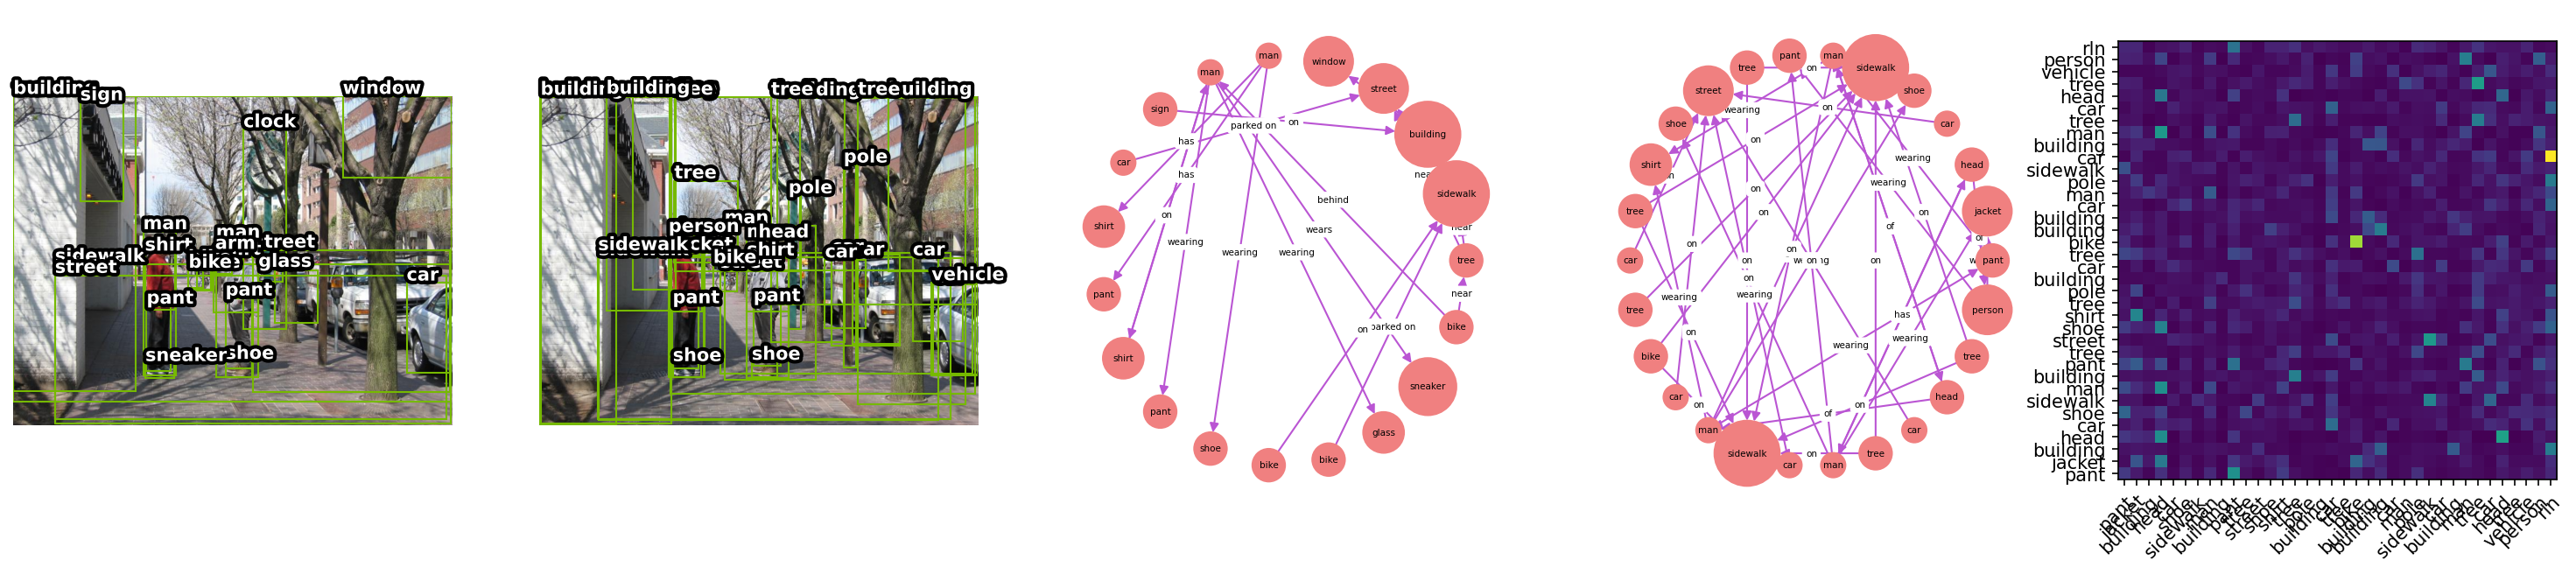

In [34]:
plot_val_rel_sample(images[0].permute(1,2,0).cpu().numpy(), bbox1, bbox2, labels1, labels2, edges1[0], edges2, atten_map)

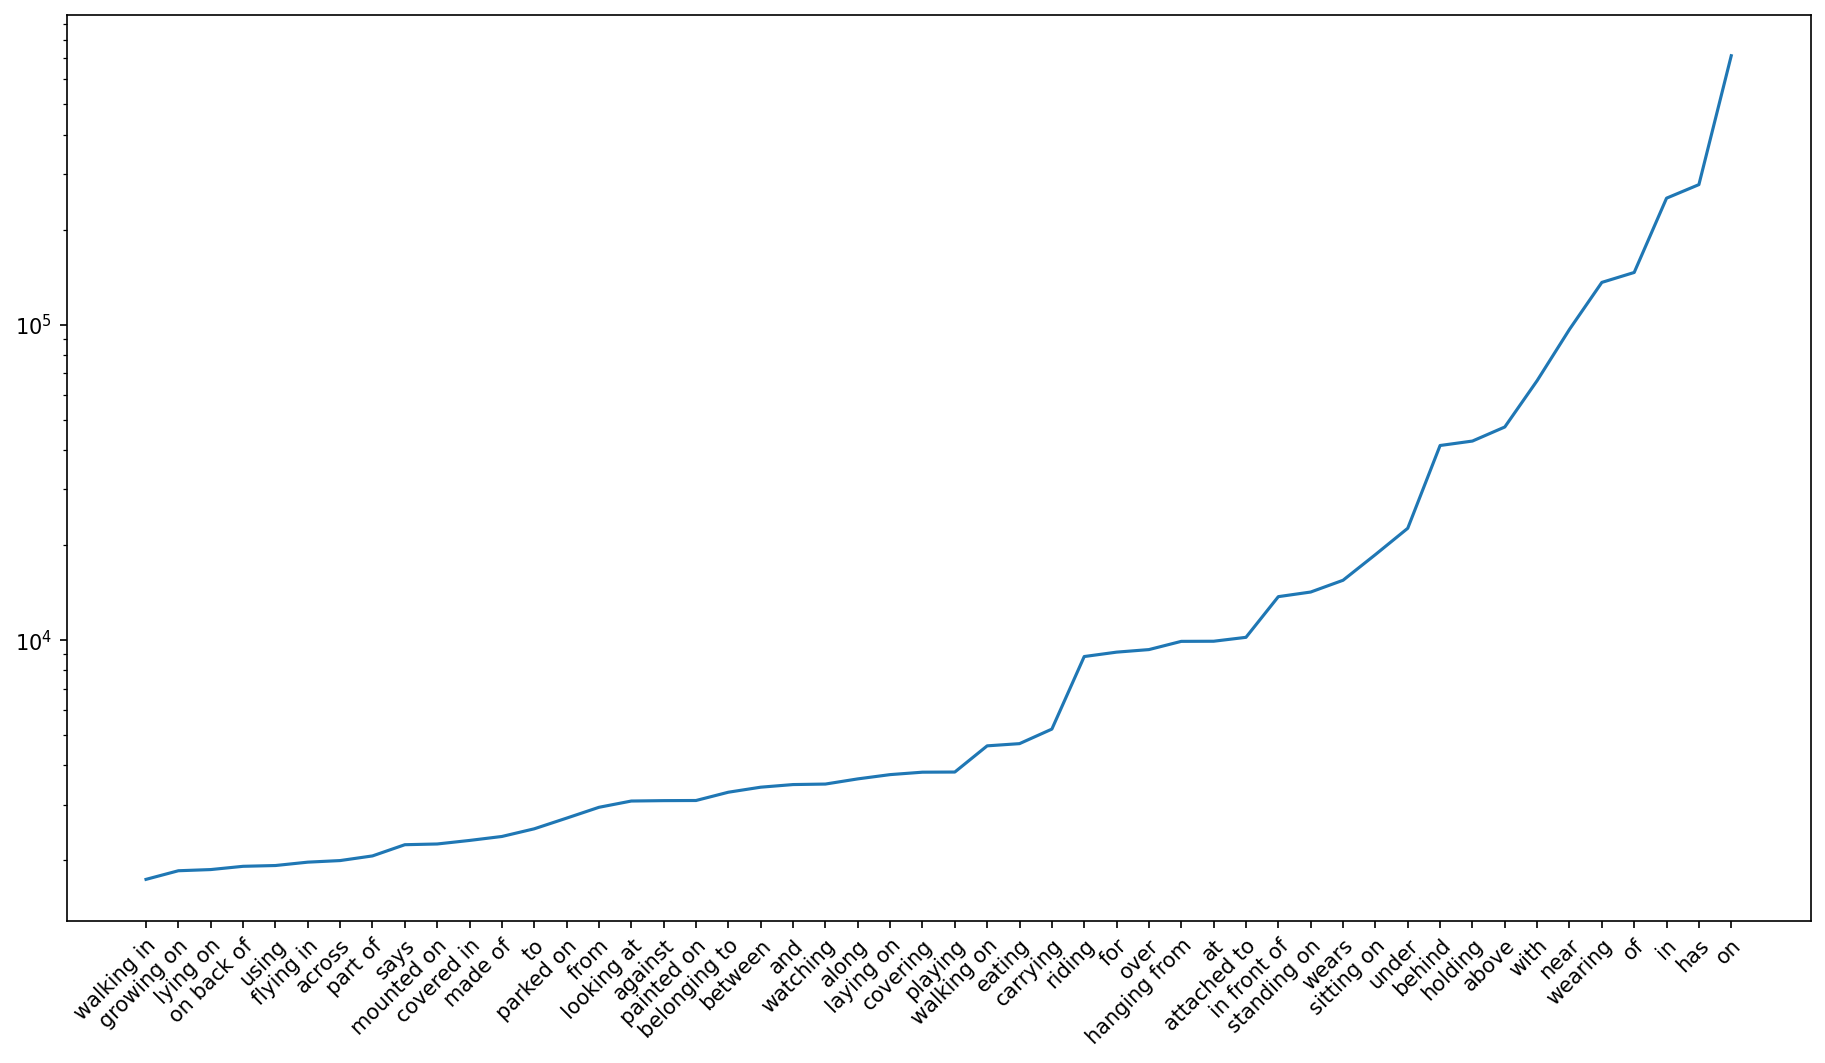

In [65]:
lists = sorted(json.load(open(config.DATA.LABEL_DATA_DIR))['predicate_count'].items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
x=np.array(x)
idx=np.argsort(y)
y=np.sort(y)
fig=plt.figure(figsize=(15,8),dpi=150)
plt.plot(x[idx], y)
plt.gca().set_yscale('log')
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
plt.show()